In [1]:
!pip install split-folders

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sayantikalaskar","key":"9c46cbc3dc0f3d53e9eef348359a288e"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone

Dataset URL: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
License(s): copyright-authors
100% 1.51G/1.52G [00:47<00:00, 39.5MB/s]
100% 1.52G/1.52G [00:47<00:00, 34.3MB/s]


In [6]:
!unzip ct-kidney-dataset-normal-cyst-tumor-and-stone.zip

Streaming output truncated to the last 5000 lines.
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4363).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4364).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4365).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4366).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4367).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4368).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4369).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-N

In [7]:
import splitfolders
splitfolders.ratio(
    "/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
   output="./dataset",
   seed=7,
   ratio=(0.7,0.15, 0.15)
)

Copying files: 12446 files [00:08, 1531.51 files/s]


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode="reflect"
)

# Create the training data generator
train_generator = train_datagen.flow_from_directory(
    './dataset/train',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64
)

# Define the validation data generator without augmentation, only rescaling
val_datagen = ImageDataGenerator(rescale=1/255.0)

# Create the validation data generator
val_generator = val_datagen.flow_from_directory(
    './dataset/val',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64
)

Found 8710 images belonging to 4 classes.
Found 1865 images belonging to 4 classes.


In [9]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2

def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        if lr > 0.0001:
            lr *= 0.1
    return lr

lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

callbacks = [lr_scheduler_callback]

In [10]:
from tensorflow.keras.layers import Layer, Conv2D, Concatenate, Multiply


class spatial_attention(Layer):
    def __init__(self):
        super(spatial_attention, self).__init__()

        self.conv2d = Conv2D(1, kernel_size=3, padding="same", activation="sigmoid")

    def call(self, inputs):
        x1 = tf.reduce_mean(inputs, axis=-1)
        x1 = tf.expand_dims(x1, axis=-1)

        x2 = tf.reduce_max(inputs, axis=-1)
        x2 = tf.expand_dims(x2, axis=-1)

        feats = Concatenate()([x1, x2])
        feats = self.conv2d(feats)
        feats = Multiply()([inputs, feats])

        return feats

In [11]:
from tensorflow.keras.optimizers import Adam

In [12]:
print(f"Number of classes in training set: {train_generator.num_classes}")
print(f"Number of classes in validation set: {val_generator.num_classes}")

Number of classes in training set: 4
Number of classes in validation set: 4


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
import tensorflow as tf

class SpatialAttention(Layer):
    def __init__(self):
        super(SpatialAttention, self).__init__()

    def build(self, input_shape):
        self.conv1 = Conv2D(filters=1, kernel_size=(7, 7), padding='same', activation='sigmoid')

    def call(self, inputs):
        attention = self.conv1(tf.reduce_mean(inputs, axis=-1, keepdims=True))
        return inputs * attention

# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3), kernel_regularizer=l2(0.01)))
model.add(SpatialAttention())
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(SpatialAttention())
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(SpatialAttention())
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(SpatialAttention())
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(SpatialAttention())
model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 spatial_attention (Spatial  (None, 224, 224, 32)      50        
 Attention)                                                      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                        

CNN-SpatialAttention

In [15]:
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer, Concatenate, Multiply
import tensorflow as tf

# Split the dataset
splitfolders.ratio(
    "/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
    output="./dataset",
    seed=7,
    ratio=(0.7, 0.15, 0.15)
)

# Define the training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode="reflect"
)

# Create the training data generator
train_generator = train_datagen.flow_from_directory(
    './dataset/train',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64
)

# Define the validation data generator without augmentation, only rescaling
val_datagen = ImageDataGenerator(rescale=1/255.0)

# Create the validation data generator
val_generator = val_datagen.flow_from_directory(
    './dataset/val',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64
)

# Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        if lr > 0.0001:
            lr *= 0.1
    return lr

lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

# Define the custom spatial attention layer
class SpatialAttention(Layer):
    def __init__(self):
        super(SpatialAttention, self).__init__()

    def build(self, input_shape):
        self.conv1 = Conv2D(filters=1, kernel_size=(7, 7), padding='same', activation='sigmoid')

    def call(self, inputs):
        attention = self.conv1(tf.reduce_mean(inputs, axis=-1, keepdims=True))
        return inputs * attention

# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3), kernel_regularizer=l2(0.01)))
model.add(SpatialAttention())
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(SpatialAttention())
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(SpatialAttention())
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(SpatialAttention())
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(SpatialAttention())
model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))  # 4 classes for classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    lr_scheduler_callback,
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks
)

Copying files: 12446 files [00:07, 1593.34 files/s]


Found 8710 images belonging to 4 classes.
Found 1865 images belonging to 4 classes.
Epoch 1/15
137/137 [==============================] - 193s 1s/step - loss: 12.8661 - accuracy: 0.6230 - val_loss: 9.2113 - val_accuracy: 0.4080 - lr: 0.0010
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


137/137 [==============================] - 145s 1s/step - loss: 5.6272 - accuracy: 0.7076 - val_loss: 4.6947 - val_accuracy: 0.4080 - lr: 0.0010
Epoch 3/15
137/137 [==============================] - 143s 1s/step - loss: 3.0898 - accuracy: 0.7194 - val_loss: 8.3649 - val_accuracy: 0.2981 - lr: 0.0010
Epoch 4/15
137/137 [==============================] - 144s 1s/step - loss: 1.9575 - accuracy: 0.7602 - val_loss: 5.0963 - val_accuracy: 0.1105 - lr: 0.0010
Epoch 5/15
137/137 [==============================] - 144s 1s/step - loss: 1.4325 - accuracy: 0.7637 - val_loss: 1.6370 - val_accuracy: 0.6150 - lr: 0.0010
Epoch 6/15
137/137 [==============================] - 153s 1s/step - loss: 1.1841 - accuracy: 0.7657 - val_loss: 2.6889 - val_accuracy: 0.2064 - lr: 0.0010
Epoch 7/15
137/137 [==============================] - 144s 1s/step - loss: 1.0020 - accuracy: 0.7885 - val_loss: 1.3112 - val_accuracy: 0.6166 - lr: 0.0010
Epoch 8/15
137/137 [==============================] - 144s 1s/step - loss: 

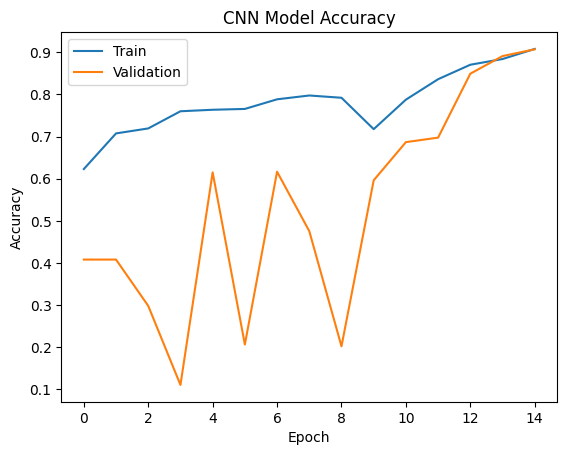

In [16]:
import matplotlib.pyplot as plt


# Plotting accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

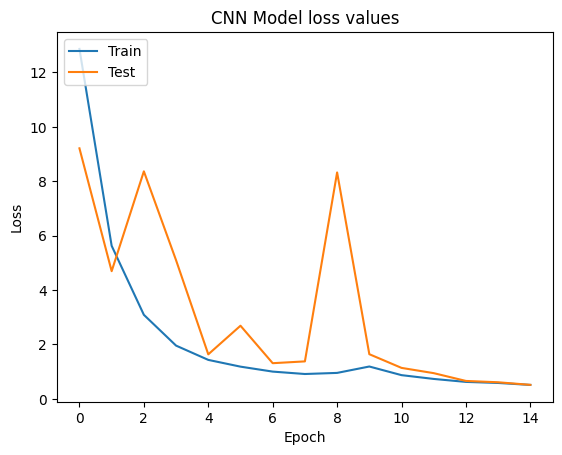

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
test_datagen = ImageDataGenerator(rescale = 1/255.0)


test_generator = train_datagen.flow_from_directory(
     './dataset/test',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 64,shuffle = False)

Found 1871 images belonging to 4 classes.


In [19]:
pred = model.predict_generator(test_generator)

<ipython-input-19-f79076686fd5>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_generator)


In [20]:
model.evaluate_generator(test_generator)

<ipython-input-20-faa0e9406f88>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[0.5200287103652954, 0.9064671397209167]

In [21]:
import numpy as np
y_pred = np.argmax(pred, axis = 1)
y_pred

array([0, 0, 0, ..., 3, 3, 3])

In [22]:
y_true = test_generator.classes

In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
cm

array([[510,   0,   7,  40],
       [  0, 749,   0,  14],
       [ 51,   7, 121,  29],
       [  0,  28,   0, 315]])

In [24]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       557
           1       0.96      0.98      0.97       763
           2       0.95      0.58      0.72       208
           3       0.79      0.92      0.85       343

    accuracy                           0.91      1871
   macro avg       0.90      0.85      0.86      1871
weighted avg       0.91      0.91      0.90      1871



<Axes: >

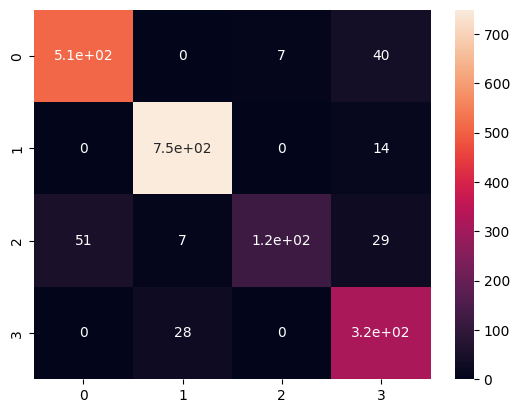

In [25]:
import seaborn as sns
sns.heatmap(cm, annot = True)

resnet

Found 8710 images belonging to 4 classes.
Found 1865 images belonging to 4 classes.
Epoch 1/12
69/69 [==============================] - ETA: 0s - loss: 0.8209 - accuracy: 0.7009

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 183s 2s/step - loss: 0.8209 - accuracy: 0.7009 - val_loss: 19.0984 - val_accuracy: 0.2890 - lr: 0.0010
Epoch 2/12
69/69 [==============================] - 140s 2s/step - loss: 0.4669 - accuracy: 0.8168 - val_loss: 20.5309 - val_accuracy: 0.2981 - lr: 0.0010
Epoch 3/12
69/69 [==============================] - 140s 2s/step - loss: 0.3439 - accuracy: 0.8684 - val_loss: 19.8942 - val_accuracy: 0.2960 - lr: 0.0010
Epoch 4/12
69/69 [==============================] - 139s 2s/step - loss: 0.2618 - accuracy: 0.9016 - val_loss: 8.5594 - val_accuracy: 0.1630 - lr: 0.0010
Epoch 5/12
69/69 [==============================] - 140s 2s/step - loss: 0.2278 - accuracy: 0.9117 - val_loss: 6.9289 - val_accuracy: 0.3399 - lr: 0.0010
Epoch 6/12
69/69 [==============================] - 140s 2s/step - loss: 0.2316 - accuracy: 0.9155 - val_loss: 0.2808 - val_accuracy: 0.8976 - lr: 0.0010
Epoch 7/12
69/69 [==============================] - 138s 2s/step - loss: 0.1625 - ac

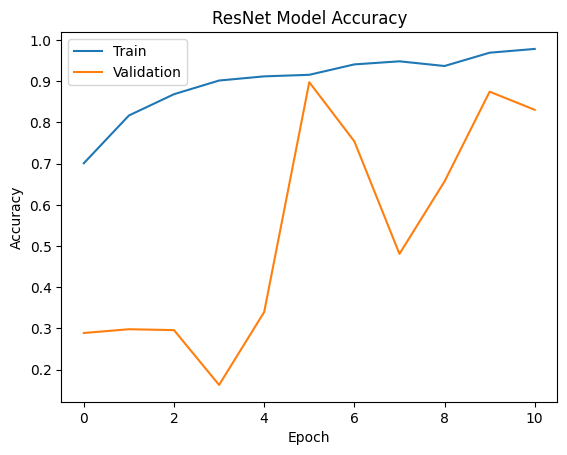

Found 1871 images belonging to 4 classes.
15/15 [==============================] - 11s 748ms/step
              precision    recall  f1-score   support

        Cyst       0.99      0.87      0.93       557
      Normal       0.92      0.94      0.93       763
       Stone       0.77      0.90      0.83       208
       Tumor       0.80      0.83      0.81       343

    accuracy                           0.90      1871
   macro avg       0.87      0.89      0.88      1871
weighted avg       0.90      0.90      0.90      1871

[[487   1  52  17]
 [  0 720   1  42]
 [  3   3 188  14]
 [  1  55   3 284]]


In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    shortcut = x
    if conv_shortcut:
        shortcut = Conv2D(filters, 1, strides=stride)(x)
        shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

def create_resnet_like_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Set parameters
input_shape = (224, 224, 3)
num_classes = 4  # Update to match the number of classes in your dataset

# Use mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Build and compile the model
model = create_resnet_like_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode="reflect"
)

train_generator = train_datagen.flow_from_directory(
    './dataset/train',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128
)

val_datagen = ImageDataGenerator(rescale=1/255.0)

val_generator = val_datagen.flow_from_directory(
    './dataset/val',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_resnet_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=12,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks
)

# Plotting accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Generate predictions for the test set
test_generator = val_datagen.flow_from_directory(
    './dataset/test',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128,
    shuffle=False
)

pred = model.predict(test_generator)
y_pred = np.argmax(pred, axis=1)

# Get the true labels from the test generator
y_true = test_generator.classes

# Get the class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

# Print the confusion matrix
print(confusion_matrix(y_true, y_pred))

Found 8710 images belonging to 4 classes.
Found 1865 images belonging to 4 classes.
Epoch 1/10
69/69 [==============================] - ETA: 0s - loss: 0.8463 - accuracy: 0.6920

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 165s 2s/step - loss: 0.8463 - accuracy: 0.6920 - val_loss: 33.4777 - val_accuracy: 0.2981 - lr: 0.0010
Epoch 2/10
69/69 [==============================] - 149s 2s/step - loss: 0.5121 - accuracy: 0.7962 - val_loss: 17.9620 - val_accuracy: 0.2981 - lr: 0.0010
Epoch 3/10
69/69 [==============================] - 146s 2s/step - loss: 0.3756 - accuracy: 0.8497 - val_loss: 10.0437 - val_accuracy: 0.2767 - lr: 0.0010
Epoch 4/10
69/69 [==============================] - 140s 2s/step - loss: 0.3301 - accuracy: 0.8710 - val_loss: 2.4653 - val_accuracy: 0.4263 - lr: 0.0010
Epoch 5/10
69/69 [==============================] - 139s 2s/step - loss: 0.2539 - accuracy: 0.9014 - val_loss: 6.4498 - val_accuracy: 0.2702 - lr: 0.0010
Epoch 6/10
69/69 [==============================] - 140s 2s/step - loss: 0.2318 - accuracy: 0.9126 - val_loss: 2.5507 - val_accuracy: 0.4836 - lr: 0.0010
Epoch 7/10
69/69 [==============================] - 138s 2s/step - loss: 0.1895 - ac

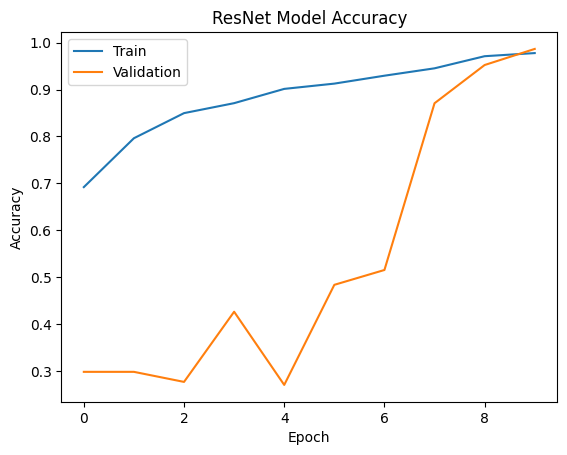

Found 1871 images belonging to 4 classes.
15/15 [==============================] - 8s 519ms/step
              precision    recall  f1-score   support

        Cyst       0.98      0.99      0.98       557
      Normal       0.99      1.00      0.99       763
       Stone       0.96      0.94      0.95       208
       Tumor       1.00      0.98      0.99       343

    accuracy                           0.99      1871
   macro avg       0.98      0.98      0.98      1871
weighted avg       0.99      0.99      0.98      1871

[[550   0   7   0]
 [  0 761   1   1]
 [ 10   2 196   0]
 [  0   7   0 336]]


In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    shortcut = x
    if conv_shortcut:
        shortcut = Conv2D(filters, 1, strides=stride)(x)
        shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

def create_resnet_like_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Set parameters
input_shape = (224, 224, 3)
num_classes = 4

# Use mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Build and compile the model
model = create_resnet_like_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode="reflect"
)

train_generator = train_datagen.flow_from_directory(
    './dataset/train',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128
)

val_datagen = ImageDataGenerator(rescale=1/255.0)

val_generator = val_datagen.flow_from_directory(
    './dataset/val',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_resnet_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks
)

# Plotting accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Generate predictions for the test set
test_generator = val_datagen.flow_from_directory(
    './dataset/test',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128,
    shuffle=False
)

pred = model.predict(test_generator)
y_pred = np.argmax(pred, axis=1)

# Get the true labels from the test generator
y_true = test_generator.classes

# Get the class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

# Print the confusion matrix
print(confusion_matrix(y_true, y_pred))

VGG

Found 8710 images belonging to 4 classes.
Found 1865 images belonging to 4 classes.
Epoch 1/8
69/69 [==============================] - ETA: 0s - loss: 1.6234 - accuracy: 0.3700

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 233s 3s/step - loss: 1.6234 - accuracy: 0.3700 - val_loss: 1.2845 - val_accuracy: 0.4080 - lr: 0.0010
Epoch 2/8
69/69 [==============================] - 178s 3s/step - loss: 1.2851 - accuracy: 0.4080 - val_loss: 1.2819 - val_accuracy: 0.4080 - lr: 0.0010
Epoch 3/8
69/69 [==============================] - 187s 3s/step - loss: 1.2862 - accuracy: 0.4079 - val_loss: 1.2809 - val_accuracy: 0.4080 - lr: 0.0010
Epoch 4/8
69/69 [==============================] - 165s 2s/step - loss: 1.2823 - accuracy: 0.4079 - val_loss: 1.2843 - val_accuracy: 0.4080 - lr: 0.0010
Epoch 5/8
69/69 [==============================] - 159s 2s/step - loss: 1.2834 - accuracy: 0.4079 - val_loss: 1.2829 - val_accuracy: 0.4080 - lr: 0.0010
Epoch 6/8
69/69 [==============================] - 159s 2s/step - loss: 1.2838 - accuracy: 0.4079 - val_loss: 1.2819 - val_accuracy: 0.4080 - lr: 0.0010
Epoch 7/8
69/69 [==============================] - 159s 2s/step - loss: 1.2822 - accuracy: 0

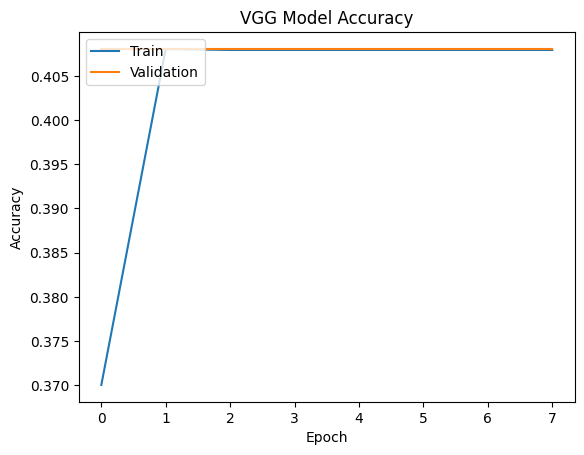

Found 1871 images belonging to 4 classes.
15/15 [==============================] - 41s 3s/step
              precision    recall  f1-score   support

        Cyst       0.00      0.00      0.00       557
      Normal       0.41      1.00      0.58       763
       Stone       0.00      0.00      0.00       208
       Tumor       0.00      0.00      0.00       343

    accuracy                           0.41      1871
   macro avg       0.10      0.25      0.14      1871
weighted avg       0.17      0.41      0.24      1871

[[  0 557   0   0]
 [  0 763   0   0]
 [  0 208   0   0]
 [  0 343   0   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def create_vgg_like_model(input_shape, num_classes):
    model = tf.keras.Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Set parameters
input_shape = (224, 224, 3)
num_classes = 4

# Use mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Build and compile the model
model = create_vgg_like_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode="reflect"
)

train_generator = train_datagen.flow_from_directory(
    './dataset/train',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128
)

val_datagen = ImageDataGenerator(rescale=1/255.0)

val_generator = val_datagen.flow_from_directory(
    './dataset/val',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_vgg_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=8,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks
)

# Plotting accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Generate predictions for the test set
test_generator = val_datagen.flow_from_directory(
    './dataset/test',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128,
    shuffle=False
)

pred = model.predict(test_generator)
y_pred = np.argmax(pred, axis=1)

# Get the true labels from the test generator
y_true = test_generator.classes

# Get the class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

# Print the confusion matrix
print(confusion_matrix(y_true, y_pred))